### CSCI E-82  Homework 3

### Due by 10/22/18 at 11:59pm EST to the Canvas dropbox

## This is an individual homework so there should be no collaboration for this homework.


### Under each problem, we have a place for you to write the answer, or write runnable code that will produce the answer.  Show your work.
-----------


## Your Name: 

Paul Washburn

## Problem 1 Climate Change (30 points) 

Scientists and politicians are often at odds on the topic of whether global warming is real and debate the various causes. This problem uses "globalWarm3.csv" data.  This is a real data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import os
os.listdir('data')

['timeSeries4.csv', 'globalWarm3.csv']

In [3]:
gw = pd.read_csv('data/globalWarm3.csv')
gw.set_index('Year', inplace=True)
gw

,Temp,CO2,Solar,Transmission,IceShelf
Year,,,,,
1980,19,338.57,1366.51,0.929667,7.85
1981,26,339.92,1366.51,0.929767,7.25
1982,4,341.30,1366.16,0.853067,7.45
1983,25,342.71,1366.18,0.897717,7.52
1984,9,344.24,1365.71,0.916492,7.17
1985,4,345.81,1365.57,0.924425,6.93
1986,12,347.11,1365.59,0.926792,7.54
1987,27,348.72,1365.67,0.929092,7.48
1988,31,351.04,1365.97,0.930125,7.49


### Problem 1a 
Plot a scatter plot of the following variables in a lattice: Temp, CO2, Solar, Transmission, and IceShelf. 
    
The variables represent the following:
- Temp = annual surface temperature measured in $1/100^{\circ} C$ over the 1950-1980 mean.
- Solar = annual mean intensity of sunlight piercing the atmosphere 
- CO2 = annual average fraction CO2 in atmosphere (#molecules/#molecules of dry air) 
- IceShelf = sea ice in 1MM square miles hypothesized to reflect heat 
- Transmission = volcanic MLO transmission data where eruptions release greenhouse gases but also decrease the temperature 




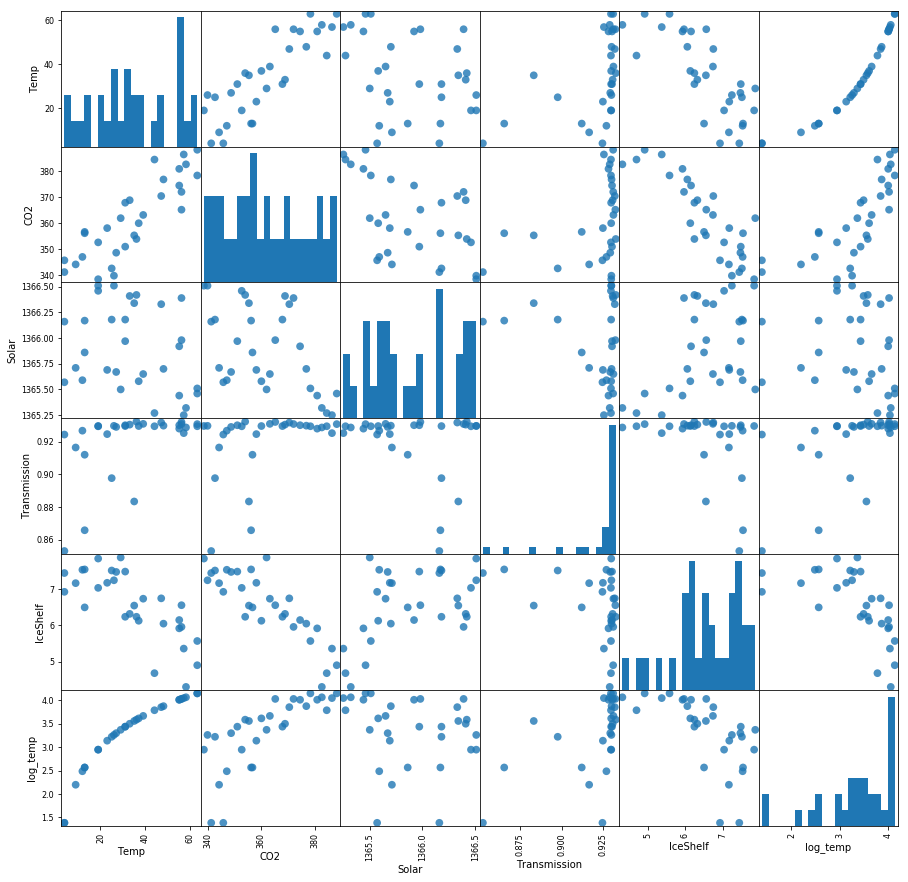

In [44]:
from sklearn.preprocessing import MinMaxScaler

pd.plotting.scatter_matrix(gw, figsize=(15, 15), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)
plt.show()

### Problem 1b 
Compute a multiple linear regression model of log(Temp) against the other variables. Note that since there are limited number of annual measurements, you cannot run all combinations of variables. In fact, you can only do complete pairwise interactions. Be sure to remove the non-significant variables while still maintaining the hierarchy principle in your final model. You do not need to show full diagnostics for the different models that you try, but do show the equations that you tried.

In [10]:
gw['log_temp'] = np.log(gw.Temp)
gw.head()

,Temp,CO2,Solar,Transmission,IceShelf,log_temp
Year,,,,,,
1980,19,338.57,1366.51,0.929667,7.85,2.944439
1981,26,339.92,1366.51,0.929767,7.25,3.258097
1982,4,341.30,1366.16,0.853067,7.45,1.386294
1983,25,342.71,1366.18,0.897717,7.52,3.218876
1984,9,344.24,1365.71,0.916492,7.17,2.197225


In [36]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

class NaFiller(BaseEstimator, TransformerMixin):
    def __init__(self, fill_val=-1):
        self.fill_val = fill_val

    def fit(self, x, y=None):
        return self

    def transform(self, data, use_mean=True):
        if use_mean:
            data = data.fillna(data.mean())
        else:
            data = data.fillna(self.fill_val)
        return data

X_cols = ['CO2', 'Solar', 'Transmission', 'IceShelf']
X, y = gw[X_cols], gw['log_temp']

pipeline = Pipeline([
    ('fillna', NaFiller()),
    ('scale', StandardScaler()),
    ('lm', LinearRegression())
])

pipeline.fit(X, y)
y_pred = pipeline.predict(X)
r2 = r2_score(y, y_pred)

print('''
R2 score = %.3f
''' %(r2))


R2 score = 0.713



### Problem 1c
Run the diagnostics to determine whether your final model is appropriate.

In [41]:
import statsmodels.api as sm

# fit using statsmodels to get access to more metrics
X_cols = ['CO2', 'Solar', 'Transmission', 'IceShelf']

# fill mean for Transmission missin gvalue
not_missing = ~gw.Transmission.isnull()
X, y = gw.loc[not_missing, X_cols], gw.loc[not_missing, 'log_temp']
X.loc[~not_missing, 'Transmission'] = X.loc[not_missing, 'Transmission'].mean()

# scale with standard scaler & add constant
X = StandardScaler().fit_transform(X)
X = sm.add_constant(X)

lm = sm.OLS(y, X)
results = lm.fit()

print(results.summary(), '\n')
print('Parameters: ')
print(results.params, '\n')
print('R2: %.3f' %results.rsquared)

                            OLS Regression Results                            
Dep. Variable:               log_temp   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     15.63
Date:                Sun, 21 Oct 2018   Prob (F-statistic):           1.57e-06
Time:                        10:08:00   Log-Likelihood:                -14.759
No. Observations:                  30   AIC:                             39.52
Df Residuals:                      25   BIC:                             46.52
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3373      0.079     42.164      0.0

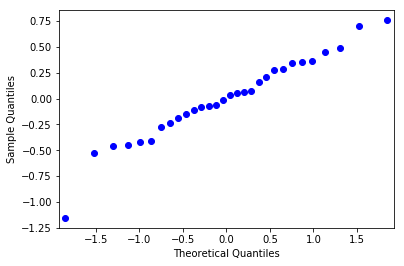

In [31]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot as plt
%matplotlib inline

res = results.resid 
fig = sm.qqplot(res)
plt.show()

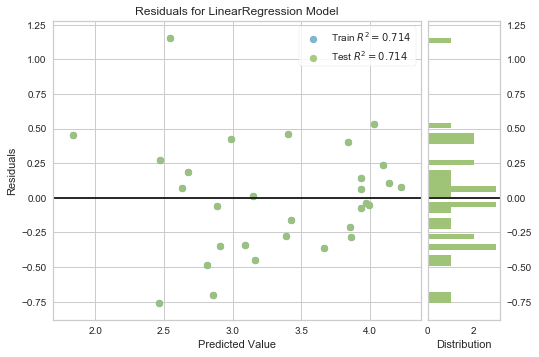

In [49]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(LinearRegression())

# fit using statsmodels to get access to more metrics
X_cols = ['CO2', 'Solar', 'Transmission', 'IceShelf']

# fill mean for Transmission missin gvalue
not_missing = ~gw.Transmission.isnull()
X, y = gw.loc[not_missing, X_cols], gw.loc[not_missing, 'log_temp']
X.loc[~not_missing, 'Transmission'] = X.loc[not_missing, 'Transmission'].mean()

# scale with standard scaler 
X = StandardScaler().fit_transform(X)

visualizer.fit(X, y)  # Fit the training data to the model
visualizer.score(X, y)  # Evaluate the model on the test data
visualizer.poof()               

### Problem 1d 

Describe in what way the model diagnostics are appropriate or not.  Be specific.

### Problem 1e

Using your knowledge of statistics, what would you conclude about climate change?

## Problem 2  Matrix model for regression (8 points)

### Problem 2a  
Using the features that you deemed important in Problem 1, construct the matrix forms of the appropriate variables.  Specifically you will need a matrix X that has the features used in your solution and a Y = logTemp.  Print the head of each of these.

In [45]:
gw.columns

Index(['Temp', 'CO2', 'Solar', 'Transmission', 'IceShelf', 'log_temp'], dtype='object')

In [47]:
# respecify X columns dropping IceShelf
X_cols = ['CO2', 'Solar', 'Transmission']
X, y = gw[X_cols], gw['log_temp']

print('X: \n', X.head(), '\n')
print('y: \n', y.head())

X: 
          CO2    Solar  Transmission
Year                               
1980  338.57  1366.51      0.929667
1981  339.92  1366.51      0.929767
1982  341.30  1366.16      0.853067
1983  342.71  1366.18      0.897717
1984  344.24  1365.71      0.916492 

y: 
 Year
1980    2.944439
1981    3.258097
1982    1.386294
1983    3.218876
1984    2.197225
Name: log_temp, dtype: float64


### Problem 2b  
Use the matrix calculation for the pseudo-inverse provided in lecture.  

```
 SSE = (YTY - 2YTXW + WTXTXW)  How to minimize this?
 Derivative wrt W and set to 0
 d/dW
 0–2XTY+2XTXW=0
◦ Note that d/dW of UTVW = VTU
◦ Last term with the W’s on either side is a quadratic which yields 2 and removal of WT
◦ XTXW = XTY  W = (XTX)-1XTY
◦ (XTX)-1XT is the Moore-Penrose
Pseudoinverse of X
 Why can’t we just do an inverse of X?
```

In [ ]:
d_dw = 0


In [53]:
# (XTX) -1XTy
np.matmul(X.T, X) -1*np.matmul(X.T, y)

array([[ 13.40992053, -11.81763217,  -1.13796581, -12.52689183],
       [-32.16098111,  33.75326948, -18.57627751,  30.04863233],
       [ -5.66301231,  -2.75797507,  17.93496703,   3.60160819],
       [-43.17758813,  19.74128497, -22.52404161,  44.06061683]])

## Problem 2c
How does the answer in Problem 2b compare to that of 1b?

## Problem 3 Time Series Modeling (40 points)

Use the data timeSeries4.csv for this problem. The data are monthly reports of production.

### Problem 3a
Plot the data and perform an exploratory analysis on the raw time series file. Comment on any trends, outliers, seasonality, whether it's stationary, etc.

In [116]:
ts_df = pd.read_csv('data/timeSeries4.csv', header=None)
ts_df.set_index(0, inplace=True) 
ts_df.head()

,1
0,
0,21.684748
1,21.622112
2,19.583297
3,23.290602
4,21.729621


In [99]:
ts_df.describe()

,1
count,148.000000
mean,24.529022
std,2.648555
min,10.521345
25%,22.811038
50%,24.536239
75%,26.703908
max,29.688140


In [71]:
ts_df.isnull().sum()

1    0
dtype: int64

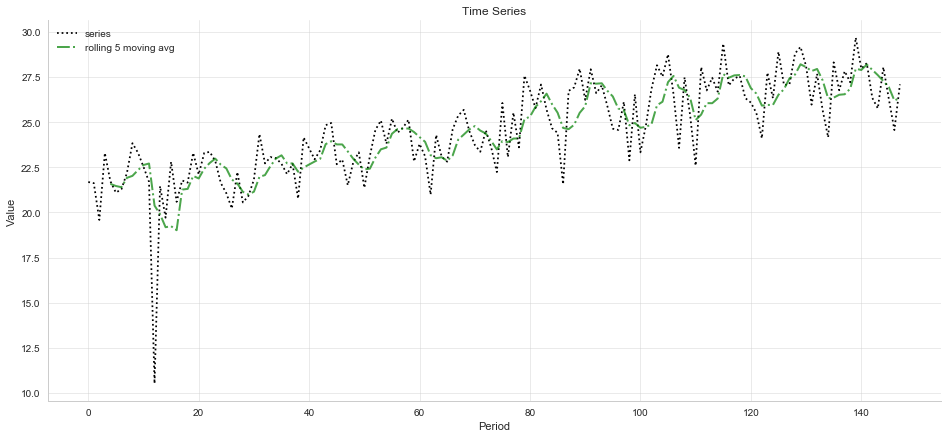

In [107]:
def set_mpl_preferences(ax):
    ax.grid(alpha=.4)
    sns.despine()

fig, ax = plt.subplots(figsize=(16, 7))
ts_df[1].plot(ax=ax, linestyle=':', color='black', label='series')
set_mpl_preferences(ax)
ax.set_title('Time Series')
ax.set_xlabel('Period')
ax.set_ylabel('Value')
ax.plot(ts_df[1].rolling(5).mean(), linestyle='-.', color='green', alpha=.7, linewidth=2, label='rolling 5 moving avg')
ax.legend(loc='best')

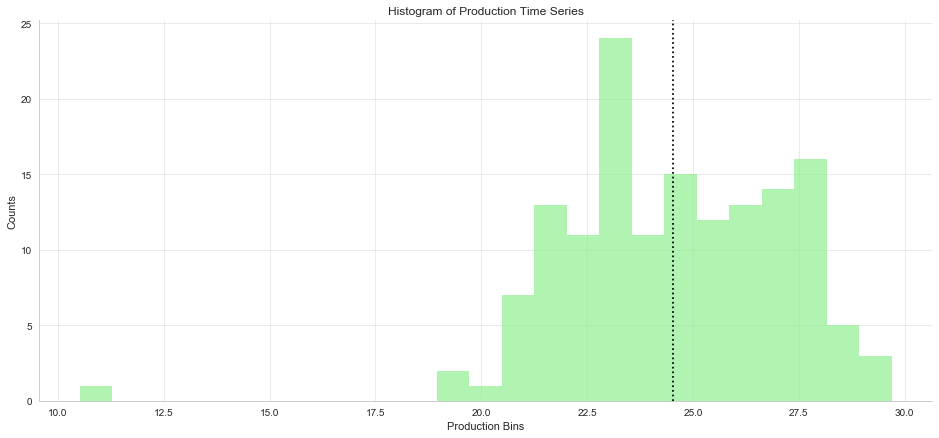

In [106]:
fig, ax = plt.subplots(figsize=(16, 7))
ts_df.hist(ax=ax, alpha=.7, color='lightgreen', bins=25)
set_mpl_preferences(ax)
ax.set_title('Histogram of Production Time Series')
ax.set_xlabel('Production Bins')
ax.set_ylabel('Counts')
ax.axvline(ts_df[1].mean(), linestyle=':', color='black', label='mean')

In [120]:
ts_df.shape[0] / 12

12.333333333333334

In [124]:
ts_df.index = pd.date_range(start='01/01/2005', periods=ts_df.shape[0], freq='M', format='%m')
ts_df.head()

,1
2005-01-31,21.684748
2005-02-28,21.622112
2005-03-31,19.583297
2005-04-30,23.290602
2005-05-31,21.729621


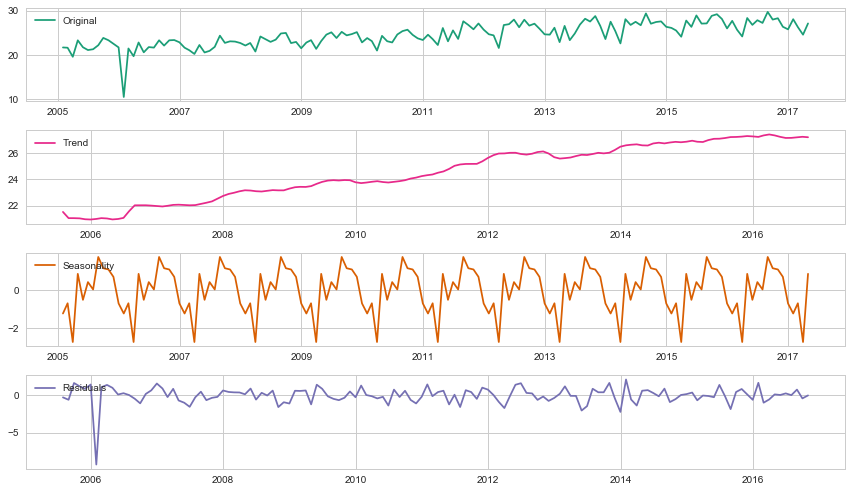

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.colors import ListedColormap

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def breakout_plots(seas_series):
    decomposition = seasonal_decompose(seas_series) 

    f, ax = plt.subplots(1,4,figsize=(12, 7))

    plt.subplot(411)
    plt.plot(seas_series, label='Original', c=dark2_colors[0])
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', c=dark2_colors[1])
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality', c=dark2_colors[2])
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', c=dark2_colors[3])
    plt.legend(loc='upper left')
    plt.tight_layout()
    
    return decomposition

decomposition = breakout_plots(ts_df[1])

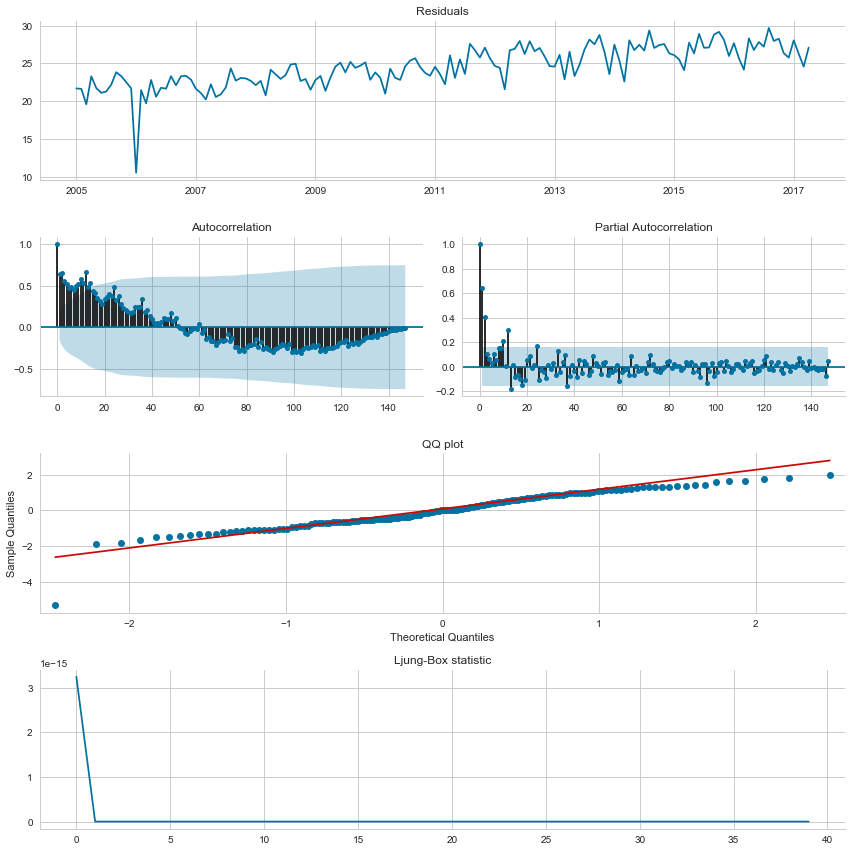

In [134]:
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 12)):
    
    q, p = sm.stats.diagnostic.acorr_ljungbox(y,lags)
    fig = plt.figure(figsize=figsize)
    layout = (4, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0), colspan=2, title='QQ plot')
    lbox_ax = plt.subplot2grid(layout, (3, 0), colspan=2, title='Ljung-Box statistic')

    y.plot(ax=ts_ax, title='Residuals')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

    qqplot(y,  line='q', ax=qq_ax, fit=True)
    if np.max(p) > 0.05:
        lbox_ax.axhline(y=0.05, xmin=0, xmax=lags, c ='r')
    lbox_ax.plot(p)
    sns.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax, lbox_ax

_ = tsplot(ts_df[1])

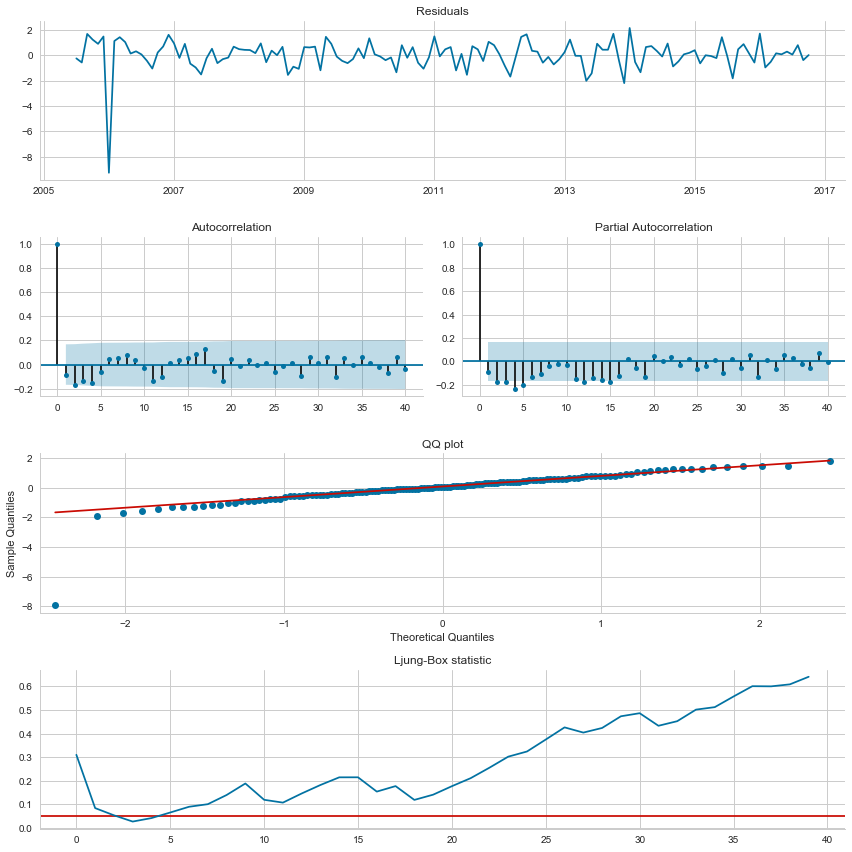

In [135]:
decomp_resid = decomposition.resid
decomp_resid.dropna(inplace=True)
_ = tsplot(decomp_resid, 40)

### Problem 3b
Using your knowledge of ACF, PACF and other diagnostics, walk us through the selection of an appropriate time series model for the data.  We are interested in both the result and your logical journey to reach that model.  That journey should begin with observations from the ACF and PACF pattern.

In [145]:
ts_df.head()

,1
2005-01-31,21.684748
2005-02-28,21.622112
2005-03-31,19.583297
2005-04-30,23.290602
2005-05-31,21.729621


In [ ]:
# arima model
mod = sm.tsa.statespace.SARIMAX(ts_df[1], trend='c', freq='M', order=(1,1,1), 
                                seasonal_order=(0,0,1,4), simple_differencing=True)

results_ARIMA = mod.fit(disp=False)
print(results_ARIMA.summary())

_ = tsplot(results_ARIMA.resid, 40)

/Users/pmw/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                               D.1   No. Observations:                  147
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 4)   Log Likelihood                -286.532
Date:                           Sun, 21 Oct 2018   AIC                            583.064
Time:                                   11:35:03   BIC                            598.016
Sample:                               02-28-2005   HQIC                           589.139
                                    - 04-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0416      0.007      6.277      0.000       0.029       0.055
ar.L1          0.1260      0.108      1.170

In [109]:
ts_df.rename(columns={1: 'value'}, inplace=True)
ts_df['log_value'] = np.log(ts_df.value)
ts_df.head()

,value,log_value
0,,
0,21.684748,3.076609
1,21.622112,3.073717
2,19.583297,2.974677
3,23.290602,3.148050
4,21.729621,3.078676


In [110]:
ts_df['diff_log_value'] = ts_df['log_value'].diff()
ts_df.head()

,value,log_value,diff_log_value
0,,,
0,21.684748,3.076609,NaN
1,21.622112,3.073717,-0.002893
2,19.583297,2.974677,-0.099040
3,23.290602,3.148050,0.173373
4,21.729621,3.078676,-0.069374


### Problem 3c
Apply and show the appropriate diagnostics to the model to assert that it is valid.  Include not just a plot but your interpretation of the plot in your justification.

## Problem 4 (15 points)

For a time series data set, a (2,1,1) was derived with the following coefficients:

const   -0.3916      
ar1      0.9172      
ar2     -0.2390      
ma1      0.4012      

The last 5 points are -104.6, -102.1, -103.2, -109.8, -115.7

Compute the next 3 data points by writing the calculation in python.  Note that this will require not only plugging values into the equation, but also taking the d term of the (p,d,q) ARIMA model into account.  We do not need a general form or function--just the required calculations.

## Problem 5 (2 points)
How many hours did this homework take you?  The answer to this question will not affect your grade.

## Last step (5 points)

Save this notebook as LastnameFirstnameHW3.ipynb such as BradyTom.ipynb. Create a pdf of this notebook named similarly. Submit both the python notebook and the pdf version to the Canvas dropbox. We require both versions.